<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES & GOOGLE AUTH**

In [1]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [2]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn


import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import os
import shutil

def organize_emotions(source_directory, target_directory):
    # Dictionary mapping from the letter in filename to emotion
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }
    
    # Create directories for each emotion if they don't exist
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(target_directory, emotion), exist_ok=True)
    
    # Iterate through each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.endswith('.wav'):  # Check if it's a WAV file
            if len(filename) > 5:  # Ensure the filename has the correct length
                emotion_code = filename[5]  # Extract the emotion letter from filename
                emotion_folder = emotion_map.get(emotion_code)
                
                if emotion_folder:  # Check if the emotion code is valid
                    # Path to the source file and target file
                    src_path = os.path.join(source_directory, filename)
                    dst_path = os.path.join(target_directory, emotion_folder, filename)
                    
                    # Copy the file to the appropriate emotion directory (instead of move)
                    shutil.copy(src_path, dst_path)
                    print(f'Copied {filename} to {emotion_folder}/')
                else:
                    print(f'Unknown emotion code "{emotion_code}" in file {filename}')
            else:
                print(f'Filename {filename} is too short to extract emotion code.')

# Usage example
source_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Update this path
target_dir = '/kaggle/working/EMODB'  # Update this path
organize_emotions(source_dir, target_dir)


import os
import csv

def create_csv_from_emotion_folders(target_directory, output_csv):
    # List of emotions that are present in the target directory
    emotions = ['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety', 'sadness']
    
    # Open the CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Emotion', 'Path'])
        
        # Iterate through each emotion folder
        for emotion in emotions:
            emotion_folder = os.path.join(target_directory, emotion)
            
            # Check if the folder exists and iterate through its files
            if os.path.exists(emotion_folder):
                for filename in os.listdir(emotion_folder):
                    if filename.endswith('.wav'):  # Ensure it's a .wav file
                        file_path = os.path.join(emotion_folder, filename)
                        writer.writerow([emotion, file_path])  # Write emotion and file path

# Usage example
target_dir = '/kaggle/working/EMODB'  # The directory where the emotion folders are located
output_csv = '/kaggle/working/Emodb.csv'  # Path to the output CSV file
create_csv_from_emotion_folders(target_dir, output_csv)

import pandas as pd
emodb = pd.read_csv("/kaggle/working/Emodb.csv")
emodb.head(10)


Copied 15a04Fd.wav to happiness/
Copied 13b02Fb.wav to happiness/
Copied 09b01Wb.wav to anger/
Copied 15a01Wa.wav to anger/
Copied 14a05Wa.wav to anger/
Copied 03a05Aa.wav to anxiety/
Copied 11a04Wc.wav to anger/
Copied 09a05Tb.wav to sadness/
Copied 12a01Wc.wav to anger/
Copied 12a04Wc.wav to anger/
Copied 09a04La.wav to boredom/
Copied 08b02Nb.wav to neutral/
Copied 12b10Wa.wav to anger/
Copied 15a07Ld.wav to boredom/
Copied 10a07La.wav to boredom/
Copied 11a05Fb.wav to happiness/
Copied 03b01Nb.wav to neutral/
Copied 12b02Ea.wav to disgust/
Copied 08a01Ab.wav to anxiety/
Copied 10a01Ac.wav to anxiety/
Copied 12a02Wa.wav to anger/
Copied 14a02Fd.wav to happiness/
Copied 09a04Wa.wav to anger/
Copied 03b01Wa.wav to anger/
Copied 15a04Nc.wav to neutral/
Copied 09a05Lc.wav to boredom/
Copied 14a01Ea.wav to disgust/
Copied 09a02La.wav to boredom/
Copied 15b03Nb.wav to neutral/
Copied 14b02Wb.wav to anger/
Copied 12a07Ac.wav to anxiety/
Copied 11b01Wd.wav to anger/
Copied 08a07Wc.wav to an

,Emotion,Path
0,disgust,/kaggle/working/EMODB/disgust/16a01Ec.wav
1,disgust,/kaggle/working/EMODB/disgust/14a04Ed.wav
2,disgust,/kaggle/working/EMODB/disgust/16a05Ea.wav
3,disgust,/kaggle/working/EMODB/disgust/14a07Eb.wav
4,disgust,/kaggle/working/EMODB/disgust/16b03Ea.wav
5,disgust,/kaggle/working/EMODB/disgust/16b01Eb.wav
6,disgust,/kaggle/working/EMODB/disgust/11a02Ec.wav
7,disgust,/kaggle/working/EMODB/disgust/10b01Ea.wav
8,disgust,/kaggle/working/EMODB/disgust/14b01Eb.wav
9,disgust,/kaggle/working/EMODB/disgust/09a07Eb.wav


# **DATA PREPROCESSING**

The preprocessing is described in the following diagram.
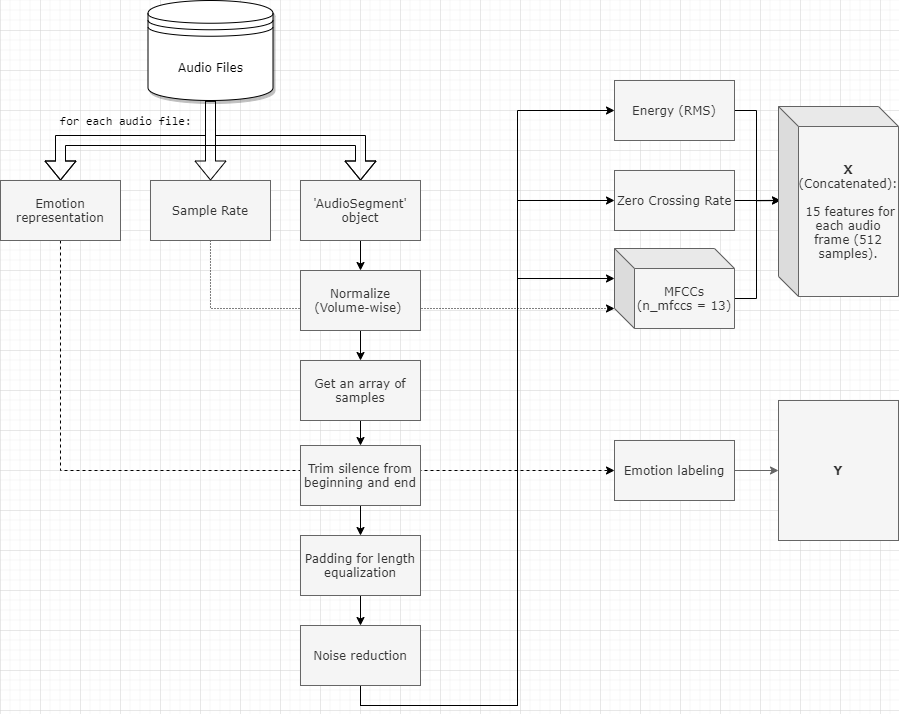

## **Initial extractions**
The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a fixed placed int that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a string representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 24.414kHz. 

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`. 
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Trimming the silence in the beginning and the end by `librosa`.
*   Padding every audio file to the maximum length by `numpy`, for length equalization.
*   Noise reduction is being performed by `noisereduce`.
---
















## **Features extraction**
The selected features being extracted with `librosa` for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length. 

**Explanation:**

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4). 

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

Audio preprocess and feature extraction is presented for a single audio file in "1_preprocess_for_one_audiofile" notebook.

In [4]:
sample_lengths = []
folder_path = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))                   

Maximum sample length: 143652


## **THE PREPROCESS**
Following the preprocessing presentation for a single audio file in "1_preprocess_for_one_audiofile" notebook, the full data will be preprocessed and extracted as the speech features chosen.

In [39]:
import os
import numpy as np
import librosa
import time
import json  # For saving as JSON

folder_path = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Folder path containing the audio files
total_length = 140000  # Desired frame length for padding/truncation
n_mfcc = 13  # Number of MFCC coefficients
frame_length = 2048
hop_length = 512

# Emotions of interest
emotion_map = {
    "W": "anger",
    "L": "boredom",
    "A": "anxiety",   
    "F": "happiness", 
    "T": "sadness", 
    "E": "disgust", 
    "N": "neutral"
}

# Initialize data lists
mfcc_features = []
emotions = []

tic = time.perf_counter()

# Iterate through all files in the specified folder
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        emotion_code = file[5]  # Extract the emotion code from the filename
        
        if emotion_code in emotion_map:
            # Load the audio file
            file_path = os.path.join(subdir, file)
            signal, sr = librosa.load(file_path, sr=16000)
            
            # Trim silence
            signal_trimmed, _ = librosa.effects.trim(signal, top_db=30)

            # Pad or truncate the audio to the fixed length
            if len(signal_trimmed) < total_length:
                signal_padded = np.pad(signal_trimmed, (0, total_length - len(signal_trimmed)), 'constant')
            else:
                signal_padded = signal_trimmed[:total_length]

            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=signal_padded, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
            mfcc = mfcc.T  # Transpose to have time frames as rows and coefficients as columns
            
            # Append the MFCC and corresponding emotion to the lists
            mfcc_features.append(mfcc)
            emotions.append(emotion_map[emotion_code])

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

# Convert the features and labels to numpy arrays for further use
X = np.array(mfcc_features, dtype='float32')
y = np.array(emotions)

print(f"MFCC features shape: {X.shape}")
print(f"Emotions shape: {y.shape}")

# Encode the labels (emotions)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(emotions)  # Converts string labels to integers
Y = np.expand_dims(Y, axis=1)

print(f"Shape of Y (Emotions/Labels): {Y.shape}")
print(f"Classes: {label_encoder.classes_}")


with open(x_path, 'w') as fp:
    json.dump(x_data, fp)

with open(y_path, 'w') as fp:
    json.dump(y_data, fp)

# Option 2: Save X and Y as NumPy binary files (more efficient for large data)
np.save('/kaggle/working/X_datanew.npy', X)
np.save('/kaggle/working/Y_datanew.npy', Y)


Running time: 0.3779 minutes
MFCC features shape: (535, 274, 13)
Emotions shape: (535,)
Shape of Y (Emotions/Labels): (535, 1)
Classes: ['anger' 'anxiety' 'boredom' 'disgust' 'happiness' 'neutral' 'sadness']


In [40]:
import numpy as np

# Load the saved .npy files
X = np.load('/kaggle/working/X_datanew.npy')  # MFCC features
Y = np.load('/kaggle/working/Y_datanew.npy')  # Emotion labels

print(f"Loaded MFCC features shape: {X.shape}")
print(f"Loaded Labels shape: {Y.shape}")

Loaded MFCC features shape: (535, 274, 13)
Loaded Labels shape: (535, 1)


# **FINAL DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format: 

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape (keras library requirement)
*   Split of X, Y to train, validation, and test sets.
*   y_train and y_validation conversion to 'One-hot' vectors for classification purposes (y_test is being converted adjacent to the test)





*   **Split X, Y To Train, Validation, and Test Sets**
*   **y_train and y_val conversion to One-Hot vectors.**



In [65]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")

Training set shape: (428, 274, 13), (428, 1)
Validation set shape: (53, 274, 13), (53, 1)
Test set shape: (54, 274, 13), (54, 1)


In [66]:
np.save('/kaggle/working/x_train.npy', x_train)
np.save('/kaggle/working/y_train.npy', y_train)

np.save('/kaggle/working/x_val.npy', x_val)
np.save('/kaggle/working/y_val.npy', y_val)

np.save('/kaggle/working/x_test.npy', x_test)
np.save('/kaggle/working/y_test.npy', y_test)

In [67]:
from tensorflow.keras.utils import to_categorical

# Assuming you have already split the dataset into training and validation sets
y_train_class = to_categorical(y_train, num_classes=7) 
y_val_class = to_categorical(y_val, num_classes=7)

# **MODEL DEFINITION & TRAIN**
The model is executed with keras library, using 2 hidden LSTM layers with 64 nodes, and an output (dense) layer with 8 nodes, each for one emotion using the 'softmax' activation.
The optimizer that led to the best results was 'RMSProp' with default parameters.

The batch size chosen is 23, which is a factor of all samples in the sets; train (3703), validation (368) and test (161).

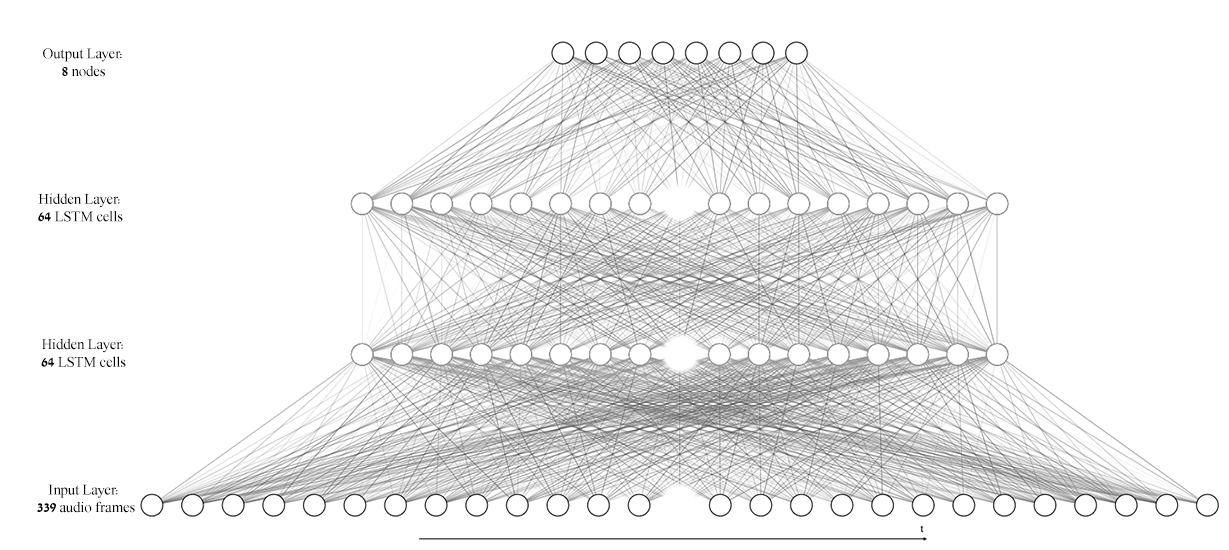

In [68]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks

# Initializing the model
model = Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))  # Correct input shape
model.add(layers.LSTM(64))
model.add(layers.Dense(7, activation='softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/kaggle/working/speech_emo_recognition.keras'

# Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

# Reduce learning rate after 100 epochs without improvement
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='RMSProp', 
              metrics=['categorical_accuracy'])

# Train the model
history = model.fit(x_train, y_train_class, 
                    epochs=100, batch_size=batch_size, 
                    validation_data=(x_val, y_val_class), 
                    callbacks=[mcp_save, rlrop])

# Load the best weights after training
model.load_weights(checkpoint_path)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 274, 64)        │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,447 (208.78 KB)

 Trainable params: 53,447 (208.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - categorical_accuracy: 0.2670 - loss: 1.8708 - val_categorical_accuracy: 0.4717 - val_loss: 1.6708 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3504 - loss: 1.5549 - val_categorical_accuracy: 0.3396 - val_loss: 1.8546 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3499 - loss: 1.5427 - val_categorical_accuracy: 0.3585 - val_loss: 1.6563 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3832 - loss: 1.4308 - val_categorical_accuracy: 0.3585 - val_loss: 1.5608 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.4465 - loss: 1.3253 - val_categorical_accuracy: 0.3585 - val_loss: 1.6388 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.4816 - loss: 1.2740 - val_categorical

# **MODEL EVALUATION**
The model has been evaluated using the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## **Train (fit) Visualization**

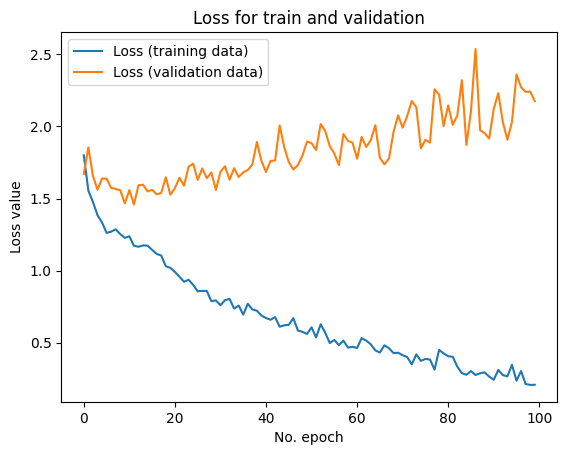

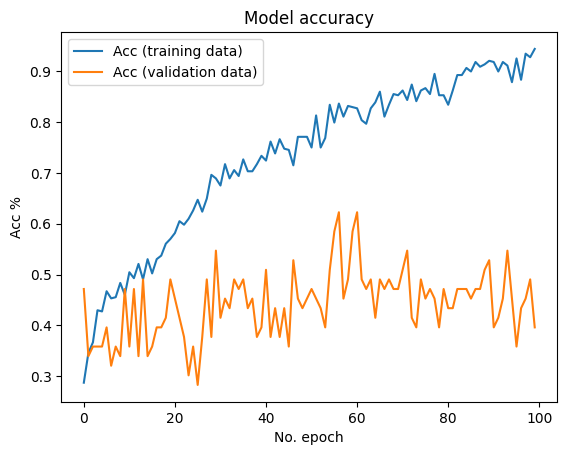

In [71]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [72]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

2/2 - 0s - 25ms/step - categorical_accuracy: 0.6226 - loss: 1.7309


**Val Set Confussion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


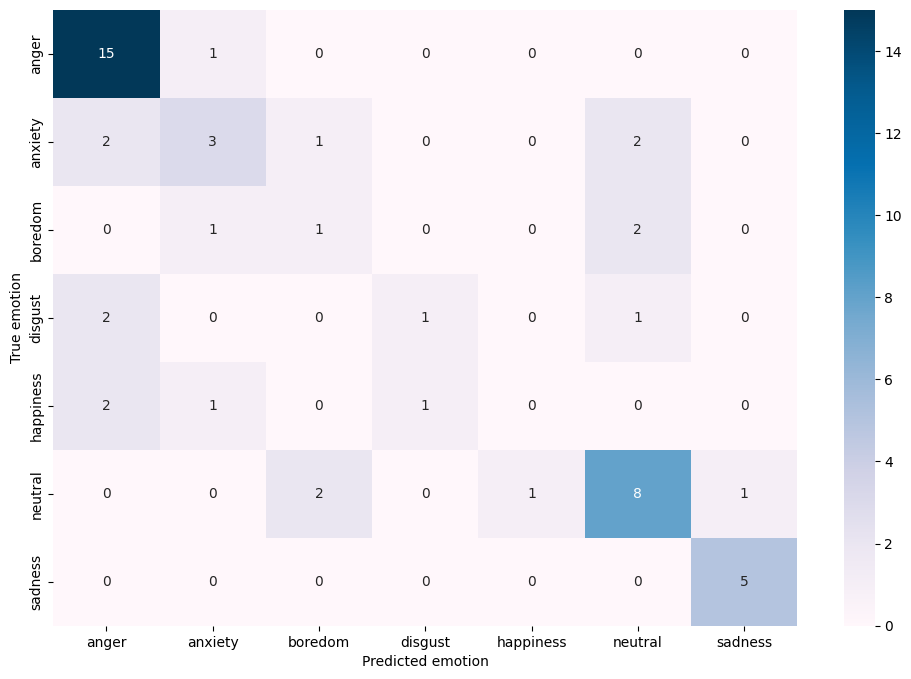

In [80]:
y_val_class = np.argmax(y_val_class, axis=1)

# Get the predictions from the model
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val_class, y_pred_class)

# Define the labels for the emotions
index = ['anger', 'anxiety', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']
columns = ['anger', 'anxiety', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=index, columns=columns)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(12, 8))
ax = plt.axes()

sns.heatmap(cm_df, ax=ax, cmap='PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

plt.show()

**Validation Set Predicted emotions accuracy**

In [74]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
anger : 0.8125
anxiety : 0.2500
boredom : 0.0000
disgust : 0.2500
happiness : 0.2500
neutral : 0.7500
sadness : 0.8000


## **Save & Load model, weights**


In [75]:
from tensorflow.keras.models import load_model

# Path to save the model and weights together
saved_model_path = '/kaggle/working/LSTM_emodb.h5'

# Save the entire model (architecture + weights)
model.save(saved_model_path)
print(f"Model saved to {saved_model_path}")


Model saved to /kaggle/working/LSTM_emodb.h5


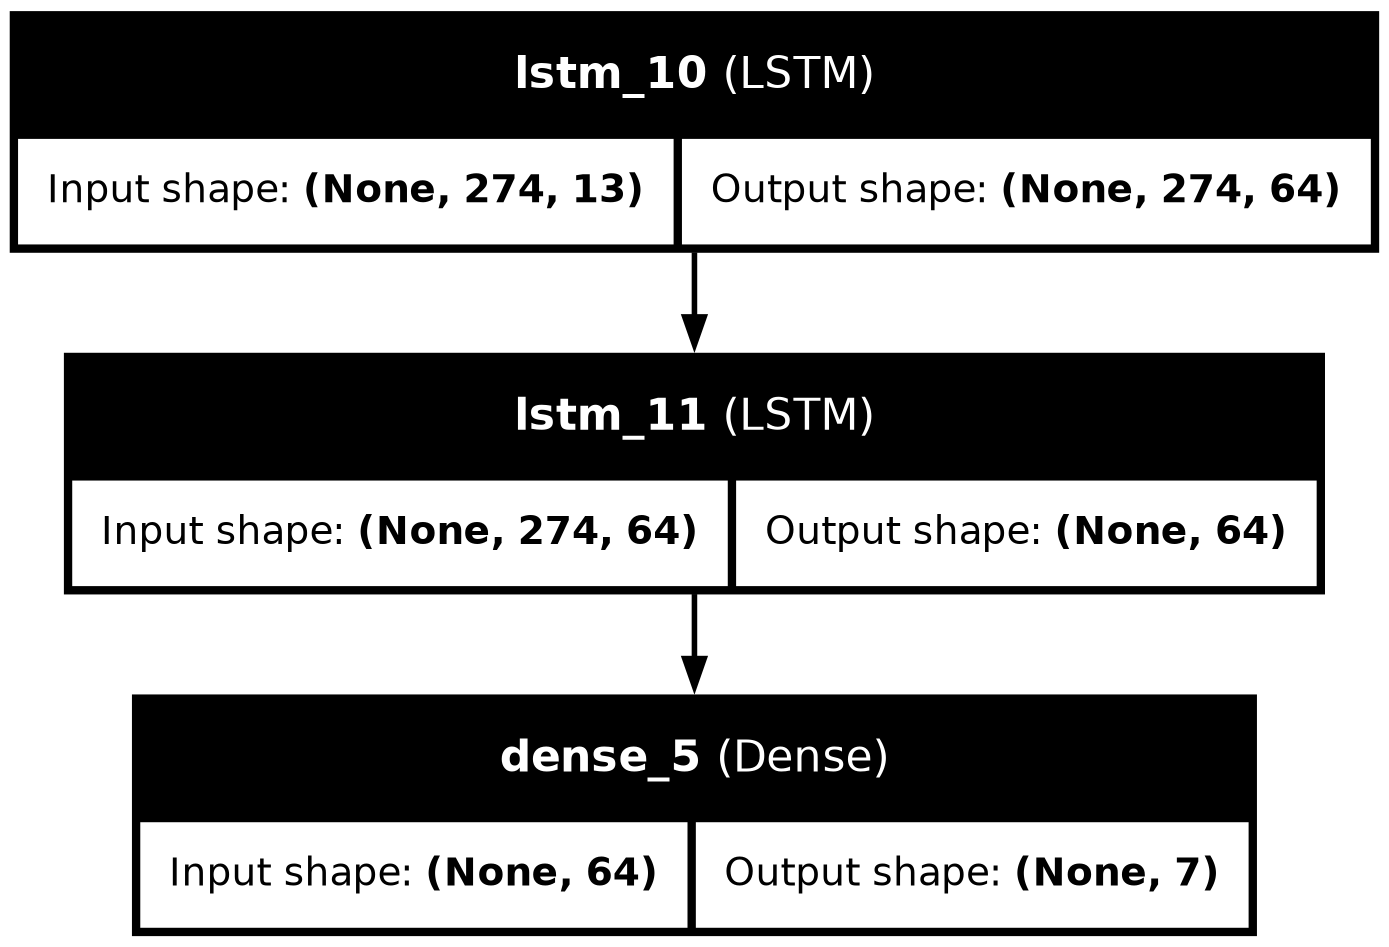

In [76]:
# Reading the model from JSON file

from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/LSTM_emodb.h5')

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [77]:
import numpy as np
from tensorflow.keras.utils import to_categorical

x_test = np.load('/kaggle/working/x_test.npy')
y_test = np.load('/kaggle/working/y_test.npy')

# Ensure x_test is in the correct data type
x_test = x_test.astype('float32')

# One-hot encode y_test
y_test_class = to_categorical(y_test, num_classes=7)

print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test_class (one-hot encoded): {y_test_class.shape}")

Shape of x_test: (54, 274, 13)
Shape of y_test_class (one-hot encoded): (54, 7)


## **Test Set Evaluation**

**Test Set Score**

In [78]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

2/2 - 1s - 519ms/step - categorical_accuracy: 0.5556 - loss: 1.1241


**Test Set Confussion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


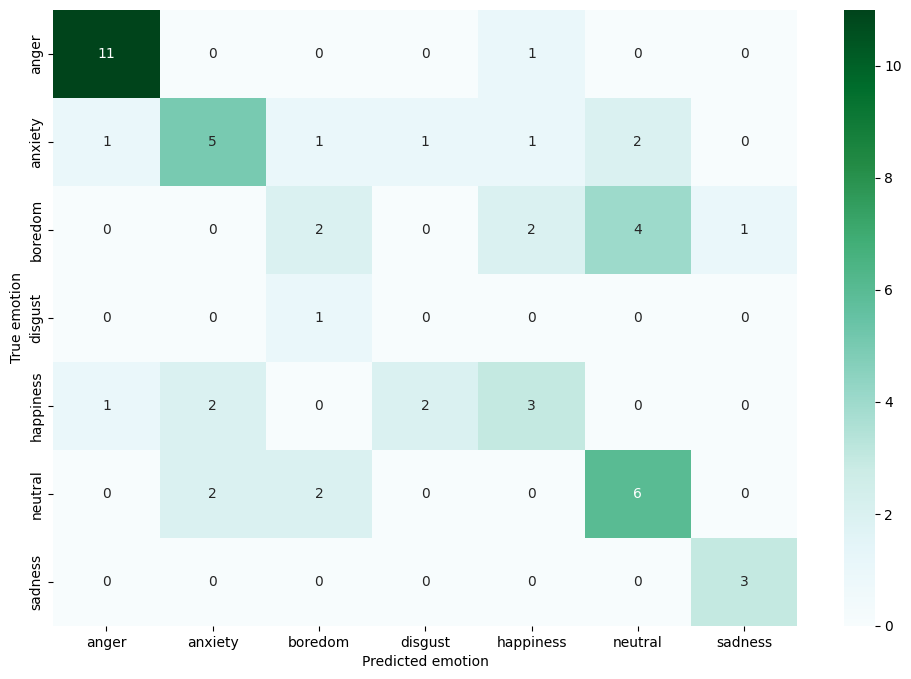

In [83]:
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Define the labels for the emotions
index = ['anger', 'anxiety', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']
columns = ['anger', 'anxiety', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=index, columns=columns)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(12, 8))
ax = plt.axes()

sns.heatmap(cm_df, ax=ax, cmap='BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

plt.show()

**Test Set Predicted emotions accuracy**

In [84]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
anger : 0.9167
anxiety : 0.4545
boredom : 0.2222
disgust : 0.0000
happiness : 0.3750
neutral : 0.6000
sadness : 1.0000
